### Review of BS_Fun and option pricing under Black–Scholes model

In [1]:
from BS_Fun import *
import seaborn as sns
import matplotlib.pyplot as plt
# Add comments about the data

In [2]:
bs_call(10,*[15,1,0,1])

2.637435891089867

In [3]:
s = np.arange(1,40,0.1)
trial = BS_Options_Pricing_S(s,[15,1,0,1])
trial.make_calls()
trial.make_puts()

<AxesSubplot:xlabel='Stock price'>

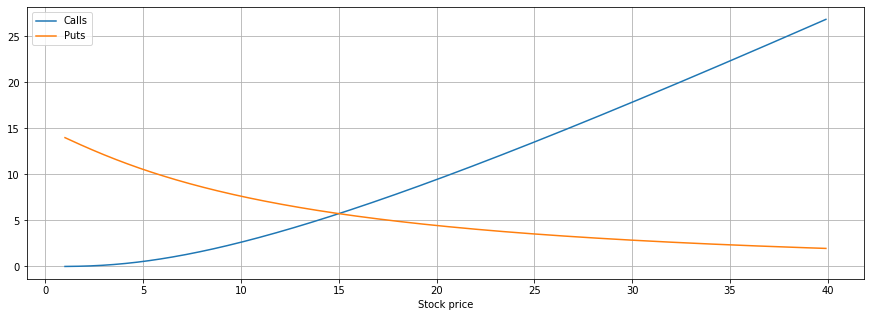

In [4]:
data=df({'Stock price':s,
    'Calls':trial.calls,
    'Puts':trial.puts}
       )
data.plot('Stock price',figsize=(15,5),legend=True,grid=True)

## Non-linear approximation
### An example of $\mathbb{R} \to \mathbb{R}$

In [5]:
def generate_sample_no_noise(S=20,K=np.arange(10,30,0.1),
                             T=1,r=0,true_sigma=1):
    '''
    We receive data over different calls, and would like to predict further on the other strike prices
    Suppose we do not have access to sigma, so we use neural networks to make the predictions.
    We first assume that we have no noise in our data :)
    '''
    trial=BS_Options_Pricing_K(K,[S,T,r,true_sigma])
    trial.make_calls()
    data =df({'Strike price':K,
    'Call price':trial.calls})
    return data

In [6]:
#(x_1,y_1),...,(x_n,y_n)
data=generate_sample_no_noise()

<AxesSubplot:xlabel='Strike price', ylabel='Call price'>

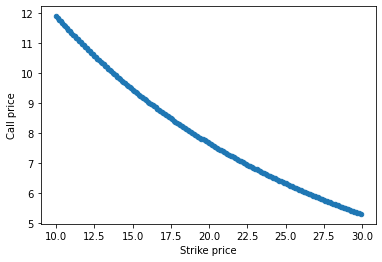

In [7]:
data.plot.scatter('Strike price','Call price')
# sns.lmplot(x='Strike price',y='Call price',data=data,fit_reg=True)

### Set up the Tensorflow
Further reamrks: https://www.tensorflow.org/tutorials/keras/regression


In [8]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.7.0


In [9]:
#If you want the results to be reproducible.
seed_value=0
tf.random.set_seed(seed_value)
np.random.seed(seed_value)

### Linear regression and loss evaluation

In [10]:
feature = data['Strike price']
target  = data['Call price']
feature_normaliser = layers.Normalization(input_shape=[1,], axis=None,name='normaliser')
feature_normaliser.adapt(feature)

In [11]:
linear_regression = keras.Sequential(name='First_model')
linear_regression.add(feature_normaliser)
linear_regression.add(layers.Dense(units=1, name='dense'))
linear_regression.summary()
linear_regression.compile(
    optimizer=tf.optimizers.SGD(learning_rate=0.1),
    loss='mean_squared_error')

Model: "First_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normaliser (Normalization)  (None, 1)                 3         
                                                                 
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


Question to discuss in group [3 mins]: why are there 5 parameters? Write down the model and illustrate these 5 parameters.

Answer (hidden to students):
Check 
```python
linear_regression.weights
```

Also write down the formula on whiteboard

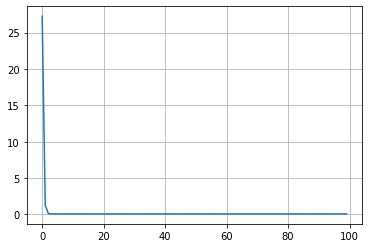

CPU times: user 1.22 s, sys: 102 ms, total: 1.33 s
Wall time: 1.13 s


In [12]:
%%time
history = linear_regression.fit(
    feature,
    target,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 0% of the training data.
    validation_split = 0,
    validation_data = None)
#Reference: https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit

plt.plot(history.history['loss'])
plt.grid(True)
plt.show()

In [13]:
# def plot_loss(history):
#   plt.plot(history.history['loss'], label='loss')
#   plt.plot(history.history['val_loss'], label='val_loss')
#   plt.ylim([0, 10])
#   plt.xlabel('Epoch')
#   plt.ylabel('Error')
#   plt.legend()
#   plt.grid(True)
# plot_loss(history)

In [14]:
linear_regression.get_weights()

[19.949999,
 33.332504,
 200,
 array([[-1.8983868]], dtype=float32),
 array([7.9929647], dtype=float32)]

In [15]:
y_pred=linear_regression.predict(feature)

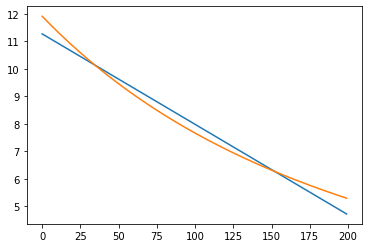

In [16]:
plt.plot(y_pred)
plt.plot(target)

In [17]:
y_pred=y_pred.reshape(target.shape)
keras.metrics.mean_squared_error(target,y_pred).numpy()

0.0790614

In [18]:
linear_regression.evaluate(feature,target,verbose=0)

0.07906139642000198

In [19]:
history.history['loss'][-1]

0.07898995280265808

### Non-linear regression

In [51]:
Model1 = keras.Sequential(name='One_layer_model')
Model1.add(feature_normaliser)
Model1.add(layers.Dense(1,activation='sigmoid',name='sigmoid'))
Model1.add(layers.Dense(1,name='dense_after_sigmoid'))
Model1.summary()
Model1.compile(
    optimizer=tf.optimizers.SGD(learning_rate=0.1),
    loss='mean_squared_error')

Model: "One_layer_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normaliser (Normalization)  (None, 1)                 3         
                                                                 
 sigmoid (Dense)             (None, 1)                 2         
                                                                 
 dense_after_sigmoid (Dense)  (None, 1)                2         
                                                                 
Total params: 7
Trainable params: 4
Non-trainable params: 3
_________________________________________________________________


Exercise and Question to discuss in group [5 mins]: Write down the formula and disuss what is expected for the result.

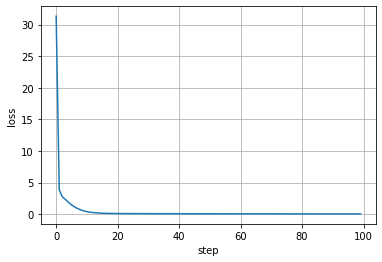

In [52]:
history = Model1.fit(
    feature,
    target,
    epochs=100,
    verbose=0,
    validation_split = 0,
    validation_data = None)

plt.plot(history.history['loss'])
plt.xlabel('step')
plt.ylabel('loss')
plt.grid(True)
plt.show()

In [22]:
Model1.get_weights()

[19.949999,
 33.332504,
 200,
 array([[-1.4967617]], dtype=float32),
 array([-0.8100089], dtype=float32),
 array([[6.801664]], dtype=float32),
 array([5.502615], dtype=float32)]

In [23]:
y_pred=Model1.predict(feature)

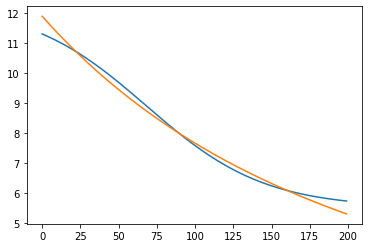

In [24]:
plt.plot(y_pred)
plt.plot(target)

In [25]:
y_pred=y_pred.reshape(target.shape)
keras.metrics.mean_squared_error(target,y_pred).numpy()

0.038151708

In [26]:
Model1.evaluate(feature,target,verbose=0)

0.038151711225509644

In [63]:
Model2 = keras.Sequential(name='Two_layers_model')
Model2.add(feature_normaliser)
Model2.add(layers.Dense(2,activation='sigmoid',name='sigmoid0'))
Model2.add(layers.Dense(2,name='linear_2X2'))
Model2.add(layers.Dense(4,activation='sigmoid',name='sigmoid1'))
Model2.add(layers.Dense(1,name='linear_4X1'))
Model2.summary()

Model: "Two_layers_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normaliser (Normalization)  (None, 1)                 3         
                                                                 
 sigmoid0 (Dense)            (None, 2)                 4         
                                                                 
 linear_2X2 (Dense)          (None, 2)                 6         
                                                                 
 sigmoid1 (Dense)            (None, 4)                 12        
                                                                 
 linear_4X1 (Dense)          (None, 1)                 5         
                                                                 
Total params: 30
Trainable params: 27
Non-trainable params: 3
_________________________________________________________________


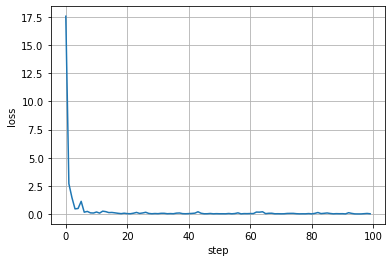

In [64]:
Model2.compile(
    optimizer=tf.optimizers.SGD(learning_rate=0.1),
    loss='mean_squared_error')

history = Model2.fit(
    feature,
    target,
    epochs=100,
    verbose=0,
    validation_split = 0,
    validation_data = None)

plt.plot(history.history['loss'])
plt.xlabel('step')
plt.ylabel('loss')
plt.grid(True)
plt.show()

0.03732769936323166

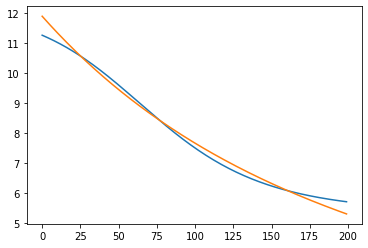

In [29]:
y_pred=Model2.predict(feature)
plt.plot(y_pred)
plt.plot(target)
Model2.evaluate(feature,target,verbose=0)

### Summary of achievements

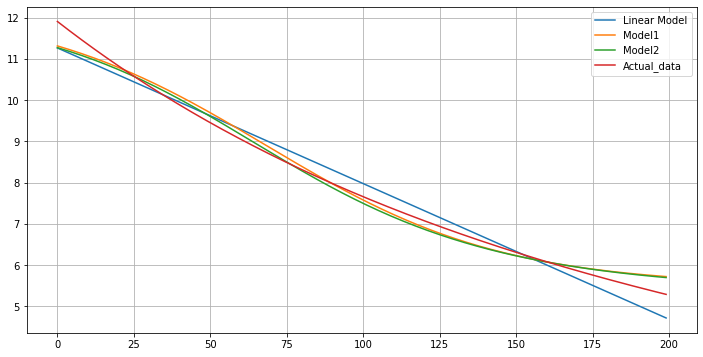

In [30]:
plt.figure(figsize=(12, 6))
plt.plot(linear_regression.predict(feature),label='Linear Model')
plt.plot(Model1.predict(feature),label='Model1')
plt.plot(Model2.predict(feature),label='Model2')
plt.plot(target,label='Actual_data')
plt.legend()
plt.grid(True)

In [31]:
# Model2 = keras.Sequential(name='Second_model_SGD')
# Model2.add(feature_normaliser)
# # Model1.add(layers.Dense(1,name='dense_pre_ELU'))
# Model2.add(layers.Dense(1,activation='sigmoid',name='sigmoid'))
# Model2.add(layers.Dense(1,name='dense_after_ELU'))
# Model2.compile(
#     optimizer=tf.optimizers.Adam(learning_rate=0.1),
#     loss='mean_squared_error')
# history = Model2.fit(
#     feature,
#     target,
#     epochs=50,
#     verbose=0)

# plt.plot(history.history['loss'])
# plt.grid(True)
# plt.show()
# y_pred=Model2.predict(feature)
# plt.plot(y_pred)
# plt.plot(target)
# Model2.evaluate(feature,target,verbose=0)

## Validation loss

In [32]:
seed_value=0
tf.random.set_seed(seed_value)
np.random.seed(seed_value)

In [33]:
data=generate_sample_no_noise(K=np.arange(1,40,0.01))
indices=np.random.randint(low=0,high=data.shape[0],size=int(data.shape[0]*0.3))
data_validiation=data.loc[indices]
data_train=data.drop(indices)

In [34]:
feature_train = data_train['Strike price']
target_train  = data_train['Call price']
feature_normaliser = layers.Normalization(input_shape=[1,], axis=None,name='normaliser')
feature_normaliser.adapt(feature_train)

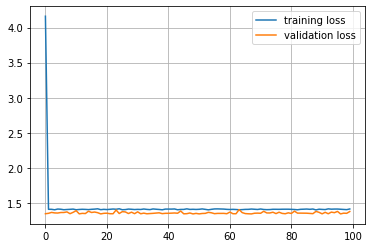

In [66]:
linear_regression = keras.Sequential(name='First_model')
linear_regression.add(feature_normaliser)
linear_regression.add(layers.Dense(units=1, name='dense'))
linear_regression.compile(
    optimizer=tf.optimizers.SGD(learning_rate=0.1),
    loss='mean_squared_error')
history0 = linear_regression.fit(
    feature_train,
    target_train,
    epochs=100,
    verbose=0,
    validation_data = (data_validiation['Strike price'],
                      data_validiation['Call price']))

plt.plot(history0.history['loss'], label='training loss')
plt.plot(history0.history['val_loss'], label='validation loss')
plt.legend()
plt.grid(True)
plt.show()

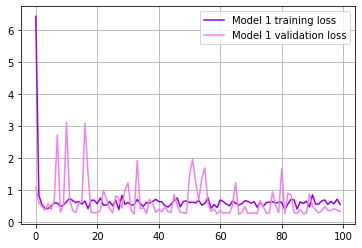

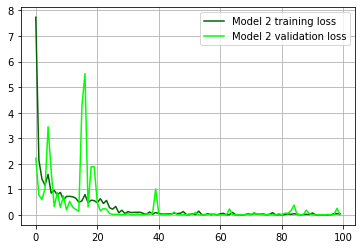

In [67]:
Model1 = keras.Sequential(name='One_layer_model')
Model1.add(feature_normaliser)
Model1.add(layers.Dense(1,activation='sigmoid',name='sigmoid'))
Model1.add(layers.Dense(1,name='dense_after_sigmoid'))
Model1.compile(
    optimizer=tf.optimizers.SGD(learning_rate=0.1),
    loss='mean_squared_error')

Model2 = keras.Sequential(name='Two_layers_model')
Model2.add(feature_normaliser)
Model2.add(layers.Dense(2,activation='sigmoid',name='sigmoid0'))
Model2.add(layers.Dense(2,name='linear_2X2'))
Model2.add(layers.Dense(4,activation='sigmoid',name='sigmoid1'))
Model2.add(layers.Dense(1,name='linear_4X1'))
Model2.compile(
    optimizer=tf.optimizers.SGD(learning_rate=0.1),
    loss='mean_squared_error')

history1 = Model1.fit(
    feature_train,
    target_train,
    epochs=100,
    verbose=0,
    validation_data = (data_validiation['Strike price'],
                      data_validiation['Call price']))

history2 = Model2.fit(
    feature_train,
    target_train,
    epochs=100,
    verbose=0,
    validation_data = (data_validiation['Strike price'],
                      data_validiation['Call price']))
plt.figure()
plt.plot(history1.history['loss'], label='Model 1 training loss',color='darkviolet')
plt.plot(history1.history['val_loss'], label='Model 1 validation loss',color='violet')
plt.legend()
plt.grid(True)

plt.figure()
plt.plot(history2.history['loss'], label='Model 2 training loss',color='darkgreen')
plt.plot(history2.history['val_loss'], label='Model 2 validation loss',color='lime')
plt.legend()
plt.grid(True)
plt.show()

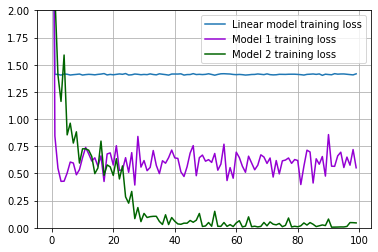

In [68]:
plt.plot(history0.history['loss'], label='Linear model training loss')
plt.plot(history1.history['loss'], label='Model 1 training loss',color='darkviolet')
plt.plot(history2.history['loss'], label='Model 2 training loss',color='darkgreen')
plt.ylim([0, 2])
plt.legend()
plt.grid(True)
plt.show()


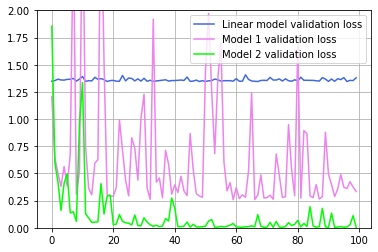

In [38]:
plt.plot(history0.history['val_loss'], label='Linear model validation loss',color='royalblue')
plt.plot(history1.history['val_loss'], label='Model 1 validation loss',color='violet')
plt.plot(history2.history['val_loss'], label='Model 2 validation loss',color='lime')
plt.ylim([0,2])
plt.legend()
plt.grid(True)
plt.show()

In [39]:
data_validiation.sort_index(ascending=True,inplace=True)

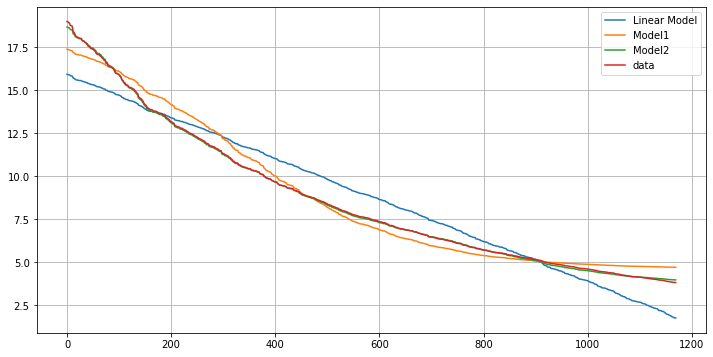

In [40]:
plt.figure(figsize=(12, 6))
plt.plot(linear_regression.predict(data_validiation['Strike price']),label='Linear Model')
plt.plot(Model1.predict(data_validiation['Strike price']),label='Model1')
plt.plot(Model2.predict(data_validiation['Strike price']),label='Model2')
plt.plot(data_validiation['Call price'].values,label='data')
plt.legend()
plt.grid(True)

## Validation / testing in unseen region

In [41]:
data_test=generate_sample_no_noise(K=np.arange(40,50,0.01))
#data points

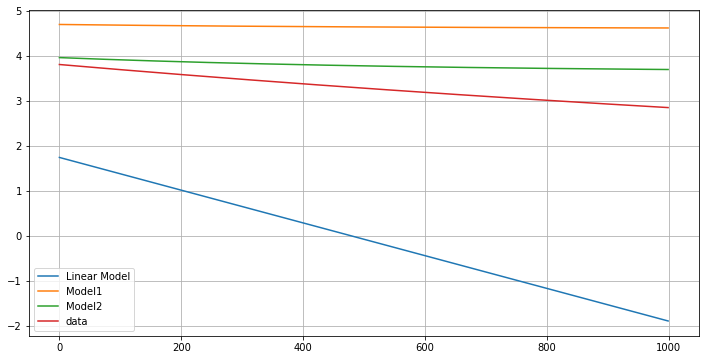

In [42]:
plt.figure(figsize=(12, 6))
plt.plot(linear_regression.predict(data_test['Strike price']),label='Linear Model')
plt.plot(Model1.predict(data_test['Strike price']),label='Model1')
plt.plot(Model2.predict(data_test['Strike price']),label='Model2')
plt.plot(data_test['Call price'].values,label='data')
plt.legend()
plt.grid(True)

In [43]:
fulldata=pd.concat([data,data_test])

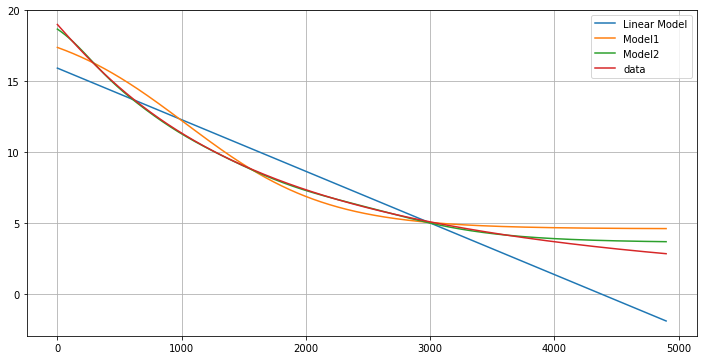

In [44]:
plt.figure(figsize=(12, 6))
plt.plot(linear_regression.predict(fulldata['Strike price']),label='Linear Model')
plt.plot(Model1.predict(fulldata['Strike price']),label='Model1')
plt.plot(Model2.predict(fulldata['Strike price']),label='Model2')
plt.plot(fulldata['Call price'].values,label='data')
plt.legend()
plt.grid(True)